In [1]:
!pip install sdv==1.4.0


In [2]:

import pandas as pd
import numpy as np
from sdv.metadata import SingleTableMetadata
from sdv.single_table import GaussianCopulaSynthesizer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from scipy.stats import ks_2samp

# Load the dataset
df = pd.read_csv("cleaned_dataset.csv")

# View structure
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3143 entries, 0 to 3142
Data columns (total 7 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Cholesterol mmol/L                        3143 non-null   float64
 1   Glucose, refridgerated serum mmol/L       3143 non-null   float64
 2   Triglyceride mmol/L                       3143 non-null   float64
 3   Haemoglobin (g/dL)                        3143 non-null   float64
 4   White blood cell count (1000 cells/ÂµL)   3143 non-null   float64
 5   Red Blood Cell Count (million cells/ÂµL)  3143 non-null   float64
 6   Target                                    3143 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 172.0 KB


,Cholesterol mmol/L,"Glucose, refridgerated serum mmol/L",Triglyceride mmol/L,Haemoglobin (g/dL),White blood cell count (1000 cells/ÂµL),Red Blood Cell Count (million cells/ÂµL),Target
0,3.284,10.16,0.576,17.2,7.2,5.53,1
1,5.353,5.77,0.847,14.5,6.6,4.72,0
2,4.319,5.94,0.723,13.5,5.2,4.66,0
3,4.500,4.50,0.271,15.1,6.0,4.81,0
4,3.362,4.94,0.158,11.9,4.6,4.59,0


In [3]:

# Metadata detection
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=df)

# Train Gaussian Copula model
model = GaussianCopulaSynthesizer(metadata)
model.fit(df)

# Generate synthetic data
synthetic_data = model.sample(len(df))
synthetic_data.head()


,Cholesterol mmol/L,"Glucose, refridgerated serum mmol/L",Triglyceride mmol/L,Haemoglobin (g/dL),White blood cell count (1000 cells/ÂµL),Red Blood Cell Count (million cells/ÂµL),Target
0,4.774,6.18,0.978,16.3,7.9,5.21,0
1,4.029,4.69,2.055,13.9,4.9,4.94,0
2,4.193,4.89,0.554,13.7,5.3,4.90,0
3,6.069,4.52,1.302,16.9,3.7,5.25,0
4,6.146,7.03,1.159,12.3,7.5,4.34,0


In [8]:
synthetic_data = model.sample(5000)
synthetic_data.to_csv("synthetic_data_gaussian_5000.csv", index=False)

In [9]:
print(synthetic_data.shape)
print(synthetic_data.head)

(5000, 7)
<bound method NDFrame.head of       Cholesterol mmol/L  Glucose, refridgerated serum mmol/L  \
0                  3.847                                 4.58   
1                  5.534                                 5.55   
2                  5.210                                 5.24   
3                  4.487                                 4.58   
4                  5.142                                 5.33   
...                  ...                                  ...   
4995               4.692                                 5.83   
4996               4.211                                 6.87   
4997               4.266                                 4.52   
4998               5.742                                 7.84   
4999               4.125                                 6.20   

      Triglyceride mmol/L  Haemoglobin (g/dL)  \
0                   1.022                13.6   
1                   1.200                12.2   
2                   0.886       

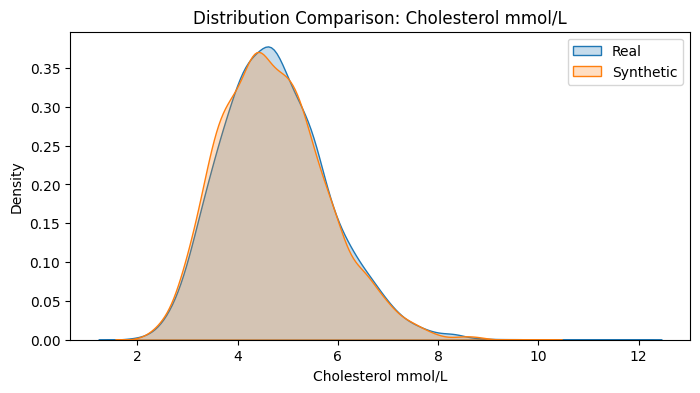

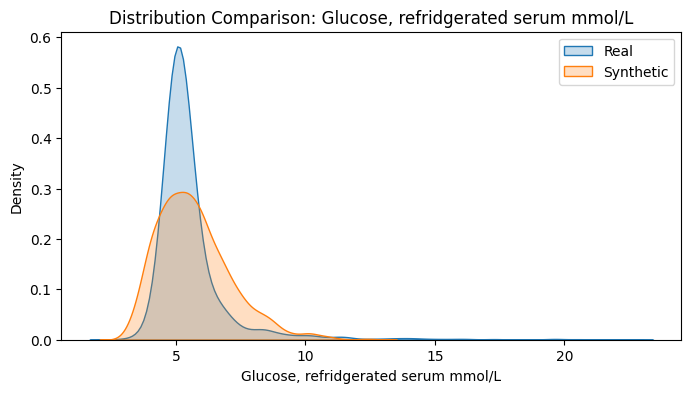

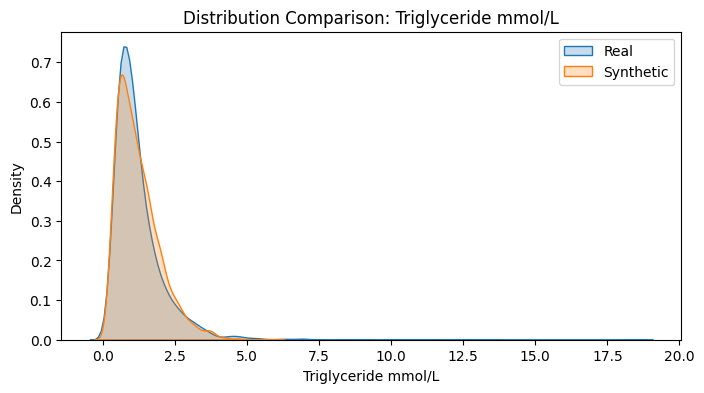

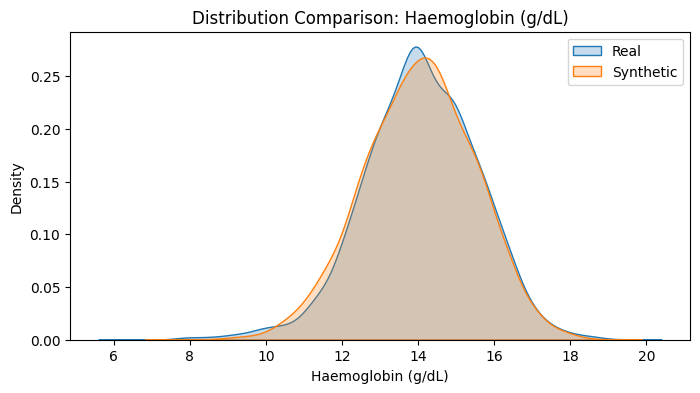

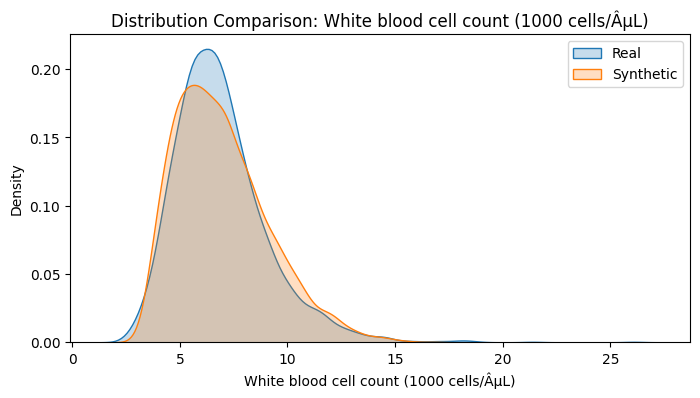

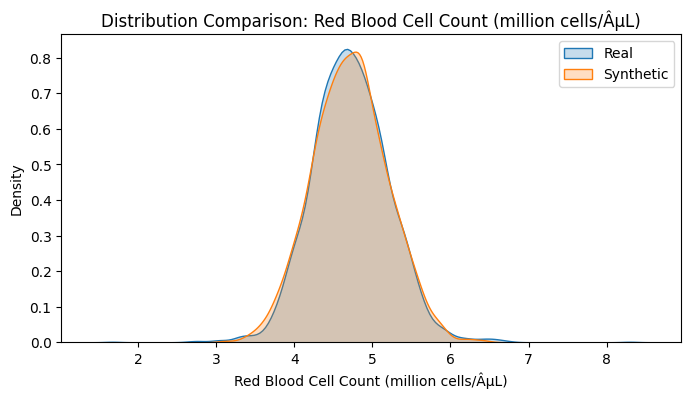

In [4]:

# Compare distributions of selected features
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
for col in numerical_cols[:-1]:  # exclude 'Target'
    plt.figure(figsize=(8, 4))
    sns.kdeplot(df[col], label='Real', fill=True)
    sns.kdeplot(synthetic_data[col], label='Synthetic', fill=True)
    plt.title(f'Distribution Comparison: {col}')
    plt.legend()
    plt.show()


In [5]:

# Perform KS Test
ks_results = []
for col in df.drop(columns='Target').columns:
    stat, p_value = ks_2samp(df[col], synthetic_data[col])
    ks_results.append((col, stat, p_value))

ks_df = pd.DataFrame(ks_results, columns=["Feature", "KS Statistic", "p-value"])
print(ks_df)


                                    Feature  KS Statistic       p-value
0                        Cholesterol mmol/L      0.032135  7.788055e-02
1       Glucose, refridgerated serum mmol/L      0.206491  4.884539e-59
2                       Triglyceride mmol/L      0.061088  1.602740e-05
3                        Haemoglobin (g/dL)      0.022590  3.990094e-01
4   White blood cell count (1000 cells/ÂµL)      0.041998  7.817823e-03
5  Red Blood Cell Count (million cells/ÂµL)      0.017817  7.007770e-01


In [6]:

# Train on synthetic, test on real
X_real = df.drop(columns='Target')
y_real = df['Target']
X_syn = synthetic_data.drop(columns='Target')
y_syn = synthetic_data['Target']

clf = RandomForestClassifier(random_state=42)
clf.fit(X_syn, y_syn)
y_pred = clf.predict(X_real)

accuracy = accuracy_score(y_real, y_pred)
print(f"Accuracy (Train on Synthetic, Test on Real): {accuracy:.4f}")


Accuracy (Train on Synthetic, Test on Real): 0.8979
